In [1]:
!pip install unsloth

In [2]:
from unsloth import FastVisionModel
import torch

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Llama-3.2-11B-Vision-Instruct",
    load_in_4bit = True,
    use_gradient_checkpointing = "unsloth",
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.3.19: Fast Mllama patching. Transformers: 4.50.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json:   0%|          | 0.00/375k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.9k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/5.15k [00:00<?, ?B/s]

In [3]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True,
    finetune_language_layers   = True,
    finetune_attention_modules = True,
    finetune_mlp_modules       = True,
    r = 16,
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    random_state = 3443,
    use_rslora = False,
    loftq_config = None,
)

Unsloth: Making `model.base_model.model.vision_model.transformer` require gradients


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shubhamgoel27/dermnet")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/dermnet


In [6]:
import os
import shutil

# Define source and destination directories
source_dir = "/kaggle/input/dermnet/test"
train_dir = "/kaggle/working/train"
test_dir = "/kaggle/working/test"

# Ensure destination directories exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Loop through class directories
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)

    if os.path.isdir(class_path):  # Ensure it's a directory
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        # List images inside class folder
        images = [img for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))]

        # Split into train (80%) and test (20%)
        train_size = int(0.8 * len(images))
        train_imgs = images[:train_size]
        test_imgs = images[train_size:]

        # Copy images
        for img in train_imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
        for img in test_imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))

print("Dataset successfully split into train and test folders.")


Dataset successfully split into train and test folders.


In [8]:
import os
import pandas as pd

# Paths
train_dir = "/kaggle/working/train"
test_dir = "/kaggle/working/test"

# Function to collect dataset information
def collect_dataset_info(split_dir, split_name):
    dataset_entries = []
    for class_name in os.listdir(split_dir):
        class_path = os.path.join(split_dir, class_name)
        if os.path.isdir(class_path):
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                if os.path.isfile(image_path):
                    dataset_entries.append({
                        'image_path': image_path,
                        'image_name': image_name,
                        'disease_category': class_name,
                        'split': split_name
                    })
    return dataset_entries

# Collect data from both folders
train_data = collect_dataset_info(train_dir, 'train')
test_data = collect_dataset_info(test_dir, 'test')

# Combine into a single DataFrame
df = pd.DataFrame(train_data + test_data)

# Print dataset info (like the Dataset(...) representation)
print("Dataset({")
print("    features:", list(df.columns), ",")
print("    num_rows:", len(df))
print("})")

# Optional: Save to CSV
df.to_csv("/kaggle/working/dermnet_metadata.csv", index=False)


Dataset({
    features: ['image_path', 'image_name', 'disease_category', 'split'] ,
    num_rows: 4002
})


In [10]:
# Show the image path
print(df.iloc[45]["image_path"])

/kaggle/working/train/Poison Ivy Photos and other Contact Dermatitis/allergic-contact-dermatitis-165.jpg


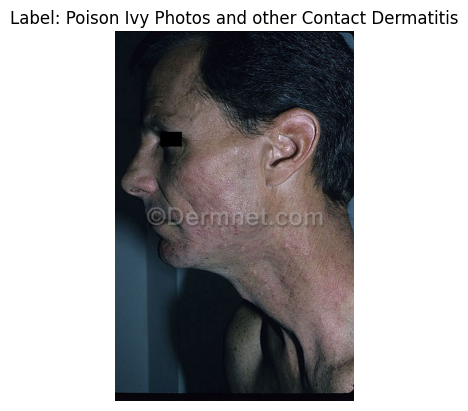

In [11]:
from PIL import Image
import matplotlib.pyplot as plt

# Load and show the image
img_path = df.iloc[45]["image_path"]
img = Image.open(img_path)

plt.imshow(img)
plt.title(f'Label: {df.iloc[45]["disease_category"]}')
plt.axis('off')
plt.show()

In [15]:
# Show the image path
print(df.iloc[45]["disease_category"])

Poison Ivy Photos and other Contact Dermatitis


In [18]:
import os
from PIL import Image

# Define the dataset path
root_dir = "/kaggle/working/train"  # or your chosen directory

# Build dataset with image object and disease category
dataset = []
for class_name in os.listdir(root_dir):
    class_path = os.path.join(root_dir, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                image = Image.open(img_path).convert("RGB")
                dataset.append({
                    "image": image,
                    "disease_category": class_name
                })
            except:
                print(f"Skipping unreadable image: {img_path}")


In [22]:
instruction = """
You are a board-certified AI dermatologist.
Please analyze the uploaded skin image carefully and provide a preliminary diagnosis using appropriate dermatological terminology.
Explain the condition briefly, mention possible treatments (e.g., topical corticosteroids, antifungals, cryotherapy), and offer warm, reassuring advice to the patient.
"""

def convert_to_consultation(sample):
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": instruction},
                {"type": "image", "image": sample["image"]},
            ],
        },
        {
            "role": "assistant",
            "content": [{
                "type": "text",
                "text": f"""Based on the visual assessment, the lesion appears consistent with **{sample["disease_category"]}**.

This condition typically manifests with the observed dermatological features and may require clinical evaluation for confirmation. In mild cases, **topical corticosteroids**, **antifungal creams**, or **cryotherapy** may be recommended, depending on the underlying pathology.

Please do not worry—many dermatological conditions are manageable and respond well to treatment. I encourage you to consult a dermatologist in person for a thorough dermoscopic evaluation and proper care.

Take care, and remember that early diagnosis leads to better outcomes. 🌼"""
            }],
        },
    ]
    return {"messages": conversation}

# Convert your dataset (with 'image' and 'disease_category' keys)
converted_dataset = [convert_to_consultation(sample) for sample in dataset]


In [23]:
converted_dataset[45]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': '\nYou are a board-certified AI dermatologist. \nPlease analyze the uploaded skin image carefully and provide a preliminary diagnosis using appropriate dermatological terminology.\nExplain the condition briefly, mention possible treatments (e.g., topical corticosteroids, antifungals, cryotherapy), and offer warm, reassuring advice to the patient.\n'},
    {'type': 'image',
     'image': <PIL.Image.Image image mode=RGB size=464x720>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'Based on the visual assessment, the lesion appears consistent with **Poison Ivy Photos and other Contact Dermatitis**.\n\nThis condition typically manifests with the observed dermatological features and may require clinical evaluation for confirmation. In mild cases, **topical corticosteroids**, **antifungal creams**, or **cryotherapy** may be recommended, depending on the underlying pathology.\n\nPlease do not

In [24]:
FastVisionModel.for_inference(model)  # Enable for inference!

image = dataset[45]["image"]

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": instruction},
        ],
    }
]
input_text = tokenizer.apply_chat_template(
    messages, add_generation_prompt=True
)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(tokenizer, skip_prompt=True)
_ = model.generate(
    **inputs,
    streamer=text_streamer,
    max_new_tokens=128,
    use_cache=True,
    temperature=1.5,
    min_p=0.1
)

* Preliminary diagnosis: Rosacea, particularly erythematotelangiectatic rosacea
* Key characteristics of rosacea include:
	+ Persistent redness and inflammation of the skin
	+ Visible blood vessels (telangiectasias)
	+ Skin appears thickened, particularly in the cheeks and nose area

**Treatments:**
* Topical corticosteroids and antibiotics for reducing redness and inflammation
* Antifungals to address secondary yeast infections
* Cryotherapy to target affected areas
* Laser therapy or light-based treatments for reducing visible blood vessels
* Lifestyle changes:
	+ Protecting skin


In [25]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model)  # Enable for training!

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    data_collator=UnslothVisionDataCollator(model, tokenizer),  # Must use!
    train_dataset=converted_dataset,
    args=SFTConfig(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        warmup_steps=5,
        max_steps=30,
        learning_rate=2e-4,
        fp16=not is_bf16_supported(),
        bf16=is_bf16_supported(),
        logging_steps=5,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="outputs",
        report_to="none",  # For Weights and Biases
        remove_unused_columns=False,
        dataset_text_field="",
        dataset_kwargs={"skip_prepare_dataset": True},
        dataset_num_proc=4,
        max_seq_length=2048,
    ),
)

In [26]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 3,192 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 67,174,400/11,000,000,000 (0.61% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
5,2.608000
10,1.112500
15,0.148000
20,0.073600
25,0.048500
30,0.045000


In [27]:
FastVisionModel.for_inference(model)  # Enable for inference!

image = dataset[45]["image"]

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": instruction},
        ],
    }
]
input_text = tokenizer.apply_chat_template(
    messages, add_generation_prompt=True
)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(tokenizer, skip_prompt=True)
_ = model.generate(
    **inputs,
    streamer=text_streamer,
    max_new_tokens=128,
    use_cache=True,
    temperature=1.5,
    min_p=0.1
)

Based on the visual assessment, the lesion appears consistent with **Eczema photos**.

This condition typically manifests with the observed dermatological features and may require clinical evaluation for confirmation. In mild cases, **topical corticosteroids**, **antifungal creams**, or **cryotherapy** may be recommended, depending on the underlying pathology.

Please do not worry—many dermatological conditions are manageable and respond well to treatment. I encourage you to consult a dermatologist in person for a thorough dermoscopic evaluation and proper care.

Take care, and remember that early diagnosis leads to better outcomes. 🌼<|eot_id|>


In [31]:
# Install the Hugging Face Hub library
!pip install -q huggingface_hub

# Import the login function
from huggingface_hub import login

# For accessing secrets in Google Colab
from google.colab import userdata

# Get your Hugging Face token from Colab Secrets
hf_token = userdata.get('huggingface')  # Make sure you added it using the key: huggingface

# Log in to Hugging Face
login(hf_token)

In [32]:
model.save_pretrained("llama_3.2_vision_skinbot") # Local saving
tokenizer.save_pretrained("llama_3.2_vision_skinbot")

[]

In [35]:
import os

print(os.listdir("llama_3.2_vision_skinbot"))

['special_tokens_map.json', 'adapter_model.safetensors', 'README.md', 'adapter_config.json', 'tokenizer.json', 'tokenizer_config.json', 'preprocessor_config.json', 'chat_template.json']


In [36]:
import os

model_path = os.path.abspath("llama_3.2_vision_skinbot")
print(model_path)


/content/llama_3.2_vision_skinbot


In [37]:
import shutil
from google.colab import files

# Create a ZIP file of your model folder
shutil.make_archive("/content/llama_3.2_vision_skinbot", 'zip', "/content/llama_3.2_vision_skinbot")

# Download the ZIP file to your local machine
files.download("/content/llama_3.2_vision_skinbot.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>